In [1]:
cd "D:\Jupyter\Cough Classification\few-shot-ho-master"

D:\Jupyter\Cough Classification\few-shot-ho-master


In [2]:
import torch
import torchaudio
import torch.nn as nn
import os
from os import listdir
import torch.nn.functional as F
from protonets.models.encoder.baseUtil import Flatten, get_padding
from collections import OrderedDict
import numpy as np

In [3]:
import os
def cough_path(file):
    '''
    get file_path and label of this file
    '''
    label = file.split("_")[0]
#     print(label)
    file_path =os.path.join(os.path.join(path, label), file)
    return file_path, label

def build_mfcc_extractor():
    '''
    extract mfcc
    '''
    frame_len = 128/ 1000
    stride = (128/2)/ 1000
    sample_rate = 16000
    mfcc = torchaudio.transforms.MFCC(sample_rate = 16000,
                                    n_mfcc=40,
                                    melkwargs={
                                        'hop_length' : int(stride*sample_rate),
                                        'n_fft' : int(frame_len*sample_rate)})
    return mfcc
    
def load_audio(filepath):
    '''
    read audio file
    '''
    desired_samples = int(16000*1000/1000)
    sound, _ = torchaudio.load(filepath=filepath,
                                     num_frames=desired_samples)
#         d[out_field] = sound
    return sound

def getData(file):
    '''step-by-step: extract feature and get label of audio file'''
    file_path, label = cough_path(file)
    sound = load_audio(file_path)
#     print("file: ", sound)
    mfcc = build_mfcc_extractor()
#     x = mfcc(sound).reshape(1,51,40)
    features = mfcc(sound)[0]
    features = features.T # f x t -> t x f
    x = torch.unsqueeze(features,0)
#     print(x.shape)
    return x, label

def euclidean_dist(x, y):
    '''calculate Euclidean distance'''
    # x: N x D
    # y: M x D
#     print(x.shape) #1, 3, 48
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
#     print(n, m, d)
#     print("y_Shape: ", y.shape) #3, 1, 48
#     print(y.size(1))
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
#     print(x)
#     print("x_u: ", x.shape)
    y = y.unsqueeze(0).expand(n, m, d)
#     print(y)
#     print("y_u: ", y.shape)
    return torch.pow(x - y, 2).sum(2)

In [4]:

# query = request.FILES.get('query', None).name
# s1 = request.FILES.get('s1', None).name
# audio.append(s1)
# s2 = request.FILES.get('s2', None).name
# audio.append(s2)
# s3 = request.FILES.get('s3', None).name
# audio.append(s3)
# s4 = request.FILES.get('s4', None).name
# audio.append(s4)

def get_support(audio):
    support = {}
    labels = []
    for file in audio:
        label = file.split("_")[0]
        if label not in labels:
            labels.append(label)
        if label not in support:
            support[label] = []
        for same in audio:
            if label == same.split("_")[0]:
                if same not in support[label]:
                    support[label].append(same)
    return support, labels

def predictLabel(query, support, labels):
    x, label = getData(query)
    xq_emb = model.encoder(x.reshape(1, 1, 16, 40))
#     print("xq_emb: ", xq_emb.shape)
    su_label = []
    su_pro = []
    for key, value in support.items():
        su_label.append(key)
        tmp = []
        check = 0
        count = 0
        for i in value:
            x, label_i = getData(i)
            feature = x.reshape(1, 1, 16, 40)
            emb = model.encoder.forward(feature).squeeze()
#             print("y_emb:", emb.shape)
            check += emb
            tmp.append(emb.detach().numpy())
            count += 1
#         print("check:", (check/3).shape)
#         print("check:", check/count, count)
        tmp = np.array(tmp)
        pro = (tmp).mean(0)
#         print("pro: ", pro)
        su_pro.append(pro)
    dists = euclidean_dist(xq_emb.reshape(1, 48), torch.tensor(su_pro))
#     dists = euclidean_dist(xq_emb.reshape(1, 9), torch.tensor(su_pro))
    n_class, n_query = torch.tensor(su_pro).shape[0], 1
    log_p_y = F.log_softmax(-dists, dim=1).view(n_class, n_query, -1)
#     print("log_py: ", log_p_y)
    g, y_hat = log_p_y.max(0)
#     print("log_py: ", log_p_y.max(0))
#     print("g, y_hat: ", g, y_hat)
    pred = labels[y_hat.squeeze()]
    return pred, label

In [5]:
path = "D:\\HoangNgan\\ThucTap\\Cough_data_Tuan1\\mono"
label_list = []
label_dict = {}
for i in listdir(path):
    if ".txt" not in i and 'aug' not in i:
        if 'whooping' not in i:
            label_list.append(i)
            label_dict[str(i)] = len(listdir(os.path.join(path, i)))
            print(str(i) + ": ", len(listdir(os.path.join(path, i))))
        else:
            label_list.append(i)
            label_dict[str(i)] = 60
            print(str(i) + ": ", label_dict[str(i)] )
    

barkingcough:  1040
chestyandwetcough:  1663
coughingupcrapagain:  884
dryafternooncough:  1040
gaggywetcough:  1117
heavycoldandsorethroatcoughing:  416
nightwetcough:  1300
springallergycoughing:  884
unknown:  1557
whoopingcough:  60


In [8]:
label_dict[label_list[1]]

1663

In [9]:
print(label_list)

['barkingcough', 'chestyandwetcough', 'coughingupcrapagain', 'dryafternooncough', 'gaggywetcough', 'heavycoldandsorethroatcoughing', 'nightwetcough', 'springallergycoughing', 'unknown', 'whoopingcough']


In [8]:
audio = []
query = "whoopingcough_30.wav"
# audio.append(query)
s1 = "unknown_1.wav"
audio.append(s1)
s2 = "unknown_1.wav"
audio.append(s2)
s3 = "unknown_11.wav"
audio.append(s3)
s4 = "unknown_21.wav"
audio.append(s4)

In [6]:
support, labels = get_support(audio)
print(support, labels)
print(predictLabel(query, support, labels))

NameError: name 'audio' is not defined

In [6]:
#setup dataset
#2way-2shot
#train
train_label = label_list[:8]
test_label = label_list[8:]

In [7]:
print(test_label)

['unknown', 'whoopingcough']


In [11]:
check_data_unk = {'0': ['unknown_1.wav', 'unknown_635.wav', 'unknown_960.wav', 'whoopingcough_5.wav', 'whoopingcough_37.wav'], '1': ['unknown_2.wav', 'unknown_394.wav', 'unknown_154.wav', 'whoopingcough_37.wav', 'whoopingcough_51.wav'], '2': ['unknown_3.wav', 'unknown_769.wav', 'unknown_568.wav', 'whoopingcough_60.wav', 'whoopingcough_22.wav'], '3': ['unknown_4.wav', 'unknown_143.wav', 'unknown_646.wav', 'whoopingcough_35.wav', 'whoopingcough_4.wav'], '4': ['unknown_5.wav', 'unknown_1551.wav', 'unknown_1500.wav', 'whoopingcough_14.wav', 'whoopingcough_48.wav'], '5': ['unknown_6.wav', 'unknown_1440.wav', 'unknown_1439.wav', 'whoopingcough_41.wav', 'whoopingcough_58.wav'], '6': ['unknown_7.wav', 'unknown_133.wav', 'unknown_752.wav', 'whoopingcough_51.wav', 'whoopingcough_52.wav'], '7': ['unknown_8.wav', 'unknown_1363.wav', 'unknown_65.wav', 'whoopingcough_37.wav', 'whoopingcough_3.wav'], '8': ['unknown_9.wav', 'unknown_753.wav', 'unknown_1540.wav', 'whoopingcough_28.wav', 'whoopingcough_32.wav'], '9': ['unknown_10.wav', 'unknown_181.wav', 'unknown_1100.wav', 'whoopingcough_18.wav', 'whoopingcough_46.wav'], '10': ['unknown_11.wav', 'unknown_1250.wav', 'unknown_551.wav', 'whoopingcough_33.wav', 'whoopingcough_1.wav'], '11': ['unknown_12.wav', 'unknown_240.wav', 'unknown_972.wav', 'whoopingcough_3.wav', 'whoopingcough_20.wav'], '12': ['unknown_13.wav', 'unknown_270.wav', 'unknown_1140.wav', 'whoopingcough_45.wav', 'whoopingcough_54.wav'], '13': ['unknown_14.wav', 'unknown_1127.wav', 'unknown_41.wav', 'whoopingcough_14.wav', 'whoopingcough_20.wav'], '14': ['unknown_15.wav', 'unknown_1358.wav', 'unknown_859.wav', 'whoopingcough_32.wav', 'whoopingcough_9.wav'], '15': ['unknown_16.wav', 'unknown_624.wav', 'unknown_258.wav', 'whoopingcough_41.wav', 'whoopingcough_52.wav'], '16': ['unknown_17.wav', 'unknown_1353.wav', 'unknown_794.wav', 'whoopingcough_54.wav', 'whoopingcough_43.wav'], '17': ['unknown_18.wav', 'unknown_669.wav', 'unknown_408.wav', 'whoopingcough_36.wav', 'whoopingcough_15.wav'], '18': ['unknown_19.wav', 'unknown_1410.wav', 'unknown_974.wav', 'whoopingcough_12.wav', 'whoopingcough_26.wav'], '19': ['unknown_20.wav', 'unknown_342.wav', 'unknown_1309.wav', 'whoopingcough_49.wav', 'whoopingcough_35.wav'], '20': ['unknown_21.wav', 'unknown_1528.wav', 'unknown_743.wav', 'whoopingcough_19.wav', 'whoopingcough_4.wav'], '21': ['unknown_22.wav', 'unknown_1256.wav', 'unknown_1193.wav', 'whoopingcough_40.wav', 'whoopingcough_60.wav'], '22': ['unknown_23.wav', 'unknown_1448.wav', 'unknown_545.wav', 'whoopingcough_36.wav', 'whoopingcough_47.wav'], '23': ['unknown_24.wav', 'unknown_1078.wav', 'unknown_1512.wav', 'whoopingcough_35.wav', 'whoopingcough_38.wav'], '24': ['unknown_25.wav', 'unknown_923.wav', 'unknown_1071.wav', 'whoopingcough_55.wav', 'whoopingcough_52.wav'], '25': ['unknown_26.wav', 'unknown_467.wav', 'unknown_1138.wav', 'whoopingcough_43.wav', 'whoopingcough_40.wav'], '26': ['unknown_27.wav', 'unknown_434.wav', 'unknown_222.wav', 'whoopingcough_22.wav', 'whoopingcough_21.wav'], '27': ['unknown_28.wav', 'unknown_241.wav', 'unknown_867.wav', 'whoopingcough_21.wav', 'whoopingcough_58.wav'], '28': ['unknown_29.wav', 'unknown_94.wav', 'unknown_1250.wav', 'whoopingcough_31.wav', 'whoopingcough_4.wav'], '29': ['unknown_30.wav', 'unknown_478.wav', 'unknown_51.wav', 'whoopingcough_10.wav', 'whoopingcough_18.wav'], '30': ['unknown_31.wav', 'unknown_1253.wav', 'unknown_1179.wav', 'whoopingcough_18.wav', 'whoopingcough_46.wav'], '31': ['unknown_32.wav', 'unknown_415.wav', 'unknown_536.wav', 'whoopingcough_40.wav', 'whoopingcough_19.wav'], '32': ['unknown_33.wav', 'unknown_1078.wav', 'unknown_235.wav', 'whoopingcough_28.wav', 'whoopingcough_56.wav'], '33': ['unknown_34.wav', 'unknown_1549.wav', 'unknown_534.wav', 'whoopingcough_7.wav', 'whoopingcough_12.wav'], '34': ['unknown_35.wav', 'unknown_1256.wav', 'unknown_747.wav', 'whoopingcough_13.wav', 'whoopingcough_14.wav'], '35': ['unknown_36.wav', 'unknown_1137.wav', 'unknown_727.wav', 'whoopingcough_41.wav', 'whoopingcough_28.wav'], '36': ['unknown_37.wav', 'unknown_1230.wav', 'unknown_490.wav', 'whoopingcough_5.wav', 'whoopingcough_53.wav'], '37': ['unknown_38.wav', 'unknown_885.wav', 'unknown_1095.wav', 'whoopingcough_46.wav', 'whoopingcough_55.wav'], '38': ['unknown_39.wav', 'unknown_1008.wav', 'unknown_660.wav', 'whoopingcough_8.wav', 'whoopingcough_36.wav'], '39': ['unknown_40.wav', 'unknown_358.wav', 'unknown_83.wav', 'whoopingcough_60.wav', 'whoopingcough_12.wav'], '40': ['unknown_41.wav', 'unknown_1514.wav', 'unknown_699.wav', 'whoopingcough_47.wav', 'whoopingcough_38.wav'], '41': ['unknown_42.wav', 'unknown_678.wav', 'unknown_1061.wav', 'whoopingcough_21.wav', 'whoopingcough_27.wav'], '42': ['unknown_43.wav', 'unknown_1416.wav', 'unknown_390.wav', 'whoopingcough_4.wav', 'whoopingcough_24.wav'], '43': ['unknown_44.wav', 'unknown_970.wav', 'unknown_759.wav', 'whoopingcough_37.wav', 'whoopingcough_25.wav'], '44': ['unknown_45.wav', 'unknown_581.wav', 'unknown_29.wav', 'whoopingcough_57.wav', 'whoopingcough_1.wav'], '45': ['unknown_46.wav', 'unknown_482.wav', 'unknown_602.wav', 'whoopingcough_32.wav', 'whoopingcough_31.wav'], '46': ['unknown_47.wav', 'unknown_1266.wav', 'unknown_588.wav', 'whoopingcough_8.wav', 'whoopingcough_49.wav'], '47': ['unknown_48.wav', 'unknown_1003.wav', 'unknown_1318.wav', 'whoopingcough_44.wav', 'whoopingcough_46.wav'], '48': ['unknown_49.wav', 'unknown_358.wav', 'unknown_1010.wav', 'whoopingcough_41.wav', 'whoopingcough_54.wav'], '49': ['unknown_50.wav', 'unknown_1549.wav', 'unknown_1023.wav', 'whoopingcough_10.wav', 'whoopingcough_24.wav'], '50': ['unknown_51.wav', 'unknown_380.wav', 'unknown_417.wav', 'whoopingcough_60.wav', 'whoopingcough_52.wav'], '51': ['unknown_52.wav', 'unknown_669.wav', 'unknown_33.wav', 'whoopingcough_11.wav', 'whoopingcough_50.wav'], '52': ['unknown_53.wav', 'unknown_8.wav', 'unknown_840.wav', 'whoopingcough_15.wav', 'whoopingcough_40.wav'], '53': ['unknown_54.wav', 'unknown_1261.wav', 'unknown_665.wav', 'whoopingcough_33.wav', 'whoopingcough_7.wav'], '54': ['unknown_55.wav', 'unknown_1542.wav', 'unknown_442.wav', 'whoopingcough_30.wav', 'whoopingcough_58.wav'], '55': ['unknown_56.wav', 'unknown_1030.wav', 'unknown_1154.wav', 'whoopingcough_5.wav', 'whoopingcough_48.wav'], '56': ['unknown_57.wav', 'unknown_981.wav', 'unknown_524.wav', 'whoopingcough_6.wav', 'whoopingcough_1.wav'], '57': ['unknown_58.wav', 'unknown_1028.wav', 'unknown_531.wav', 'whoopingcough_26.wav', 'whoopingcough_46.wav'], '58': ['unknown_59.wav', 'unknown_285.wav', 'unknown_454.wav', 'whoopingcough_14.wav', 'whoopingcough_35.wav'], '59': ['unknown_60.wav', 'unknown_603.wav', 'unknown_1003.wav', 'whoopingcough_6.wav', 'whoopingcough_56.wav']}

In [12]:
check_data_wh = {'0': ['whoopingcough_1.wav', 'whoopingcough_18.wav', 'whoopingcough_27.wav', 'unknown_660.wav', 'unknown_144.wav'], '1': ['whoopingcough_2.wav', 'whoopingcough_6.wav', 'whoopingcough_30.wav', 'unknown_299.wav', 'unknown_1260.wav'], '2': ['whoopingcough_3.wav', 'whoopingcough_15.wav', 'whoopingcough_4.wav', 'unknown_554.wav', 'unknown_739.wav'], '3': ['whoopingcough_4.wav', 'whoopingcough_34.wav', 'whoopingcough_28.wav', 'unknown_1324.wav', 'unknown_188.wav'], '4': ['whoopingcough_5.wav', 'whoopingcough_52.wav', 'whoopingcough_47.wav', 'unknown_1438.wav', 'unknown_196.wav'], '5': ['whoopingcough_6.wav', 'whoopingcough_3.wav', 'whoopingcough_11.wav', 'unknown_900.wav', 'unknown_675.wav'], '6': ['whoopingcough_7.wav', 'whoopingcough_19.wav', 'whoopingcough_32.wav', 'unknown_933.wav', 'unknown_1198.wav'], '7': ['whoopingcough_8.wav', 'whoopingcough_13.wav', 'whoopingcough_45.wav', 'unknown_558.wav', 'unknown_1230.wav'], '8': ['whoopingcough_9.wav', 'whoopingcough_11.wav', 'whoopingcough_50.wav', 'unknown_708.wav', 'unknown_1462.wav'], '9': ['whoopingcough_10.wav', 'whoopingcough_16.wav', 'whoopingcough_54.wav', 'unknown_335.wav', 'unknown_783.wav'], '10': ['whoopingcough_11.wav', 'whoopingcough_35.wav', 'whoopingcough_10.wav', 'unknown_831.wav', 'unknown_729.wav'], '11': ['whoopingcough_12.wav', 'whoopingcough_11.wav', 'whoopingcough_56.wav', 'unknown_234.wav', 'unknown_1450.wav'], '12': ['whoopingcough_13.wav', 'whoopingcough_16.wav', 'whoopingcough_40.wav', 'unknown_1403.wav', 'unknown_1234.wav'], '13': ['whoopingcough_14.wav', 'whoopingcough_28.wav', 'whoopingcough_56.wav', 'unknown_516.wav', 'unknown_475.wav'], '14': ['whoopingcough_15.wav', 'whoopingcough_14.wav', 'whoopingcough_18.wav', 'unknown_145.wav', 'unknown_1063.wav'], '15': ['whoopingcough_16.wav', 'whoopingcough_51.wav', 'whoopingcough_49.wav', 'unknown_267.wav', 'unknown_1003.wav'], '16': ['whoopingcough_17.wav', 'whoopingcough_24.wav', 'whoopingcough_57.wav', 'unknown_165.wav', 'unknown_1190.wav'], '17': ['whoopingcough_18.wav', 'whoopingcough_60.wav', 'whoopingcough_35.wav', 'unknown_1039.wav', 'unknown_125.wav'], '18': ['whoopingcough_19.wav', 'whoopingcough_36.wav', 'whoopingcough_58.wav', 'unknown_678.wav', 'unknown_1118.wav'], '19': ['whoopingcough_20.wav', 'whoopingcough_18.wav', 'whoopingcough_15.wav', 'unknown_887.wav', 'unknown_792.wav'], '20': ['whoopingcough_21.wav', 'whoopingcough_18.wav', 'whoopingcough_17.wav', 'unknown_107.wav', 'unknown_569.wav'], '21': ['whoopingcough_22.wav', 'whoopingcough_52.wav', 'whoopingcough_28.wav', 'unknown_117.wav', 'unknown_114.wav'], '22': ['whoopingcough_23.wav', 'whoopingcough_17.wav', 'whoopingcough_40.wav', 'unknown_23.wav', 'unknown_40.wav'], '23': ['whoopingcough_24.wav', 'whoopingcough_6.wav', 'whoopingcough_18.wav', 'unknown_52.wav', 'unknown_264.wav'], '24': ['whoopingcough_25.wav', 'whoopingcough_52.wav', 'whoopingcough_38.wav', 'unknown_1423.wav', 'unknown_548.wav'], '25': ['whoopingcough_26.wav', 'whoopingcough_3.wav', 'whoopingcough_24.wav', 'unknown_213.wav', 'unknown_386.wav'], '26': ['whoopingcough_27.wav', 'whoopingcough_59.wav', 'whoopingcough_24.wav', 'unknown_1288.wav', 'unknown_115.wav'], '27': ['whoopingcough_28.wav', 'whoopingcough_3.wav', 'whoopingcough_60.wav', 'unknown_948.wav', 'unknown_137.wav'], '28': ['whoopingcough_29.wav', 'whoopingcough_44.wav', 'whoopingcough_32.wav', 'unknown_141.wav', 'unknown_1134.wav'], '29': ['whoopingcough_30.wav', 'whoopingcough_36.wav', 'whoopingcough_51.wav', 'unknown_597.wav', 'unknown_841.wav'], '30': ['whoopingcough_31.wav', 'whoopingcough_51.wav', 'whoopingcough_49.wav', 'unknown_316.wav', 'unknown_978.wav'], '31': ['whoopingcough_32.wav', 'whoopingcough_28.wav', 'whoopingcough_51.wav', 'unknown_764.wav', 'unknown_141.wav'], '32': ['whoopingcough_33.wav', 'whoopingcough_53.wav', 'whoopingcough_4.wav', 'unknown_1528.wav', 'unknown_390.wav'], '33': ['whoopingcough_34.wav', 'whoopingcough_14.wav', 'whoopingcough_10.wav', 'unknown_1435.wav', 'unknown_1192.wav'], '34': ['whoopingcough_35.wav', 'whoopingcough_28.wav', 'whoopingcough_49.wav', 'unknown_393.wav', 'unknown_110.wav'], '35': ['whoopingcough_36.wav', 'whoopingcough_13.wav', 'whoopingcough_31.wav', 'unknown_282.wav', 'unknown_27.wav'], '36': ['whoopingcough_37.wav', 'whoopingcough_26.wav', 'whoopingcough_23.wav', 'unknown_951.wav', 'unknown_497.wav'], '37': ['whoopingcough_38.wav', 'whoopingcough_50.wav', 'whoopingcough_19.wav', 'unknown_1220.wav', 'unknown_1089.wav'], '38': ['whoopingcough_39.wav', 'whoopingcough_50.wav', 'whoopingcough_28.wav', 'unknown_1366.wav', 'unknown_1367.wav'], '39': ['whoopingcough_40.wav', 'whoopingcough_20.wav', 'whoopingcough_30.wav', 'unknown_811.wav', 'unknown_420.wav'], '40': ['whoopingcough_41.wav', 'whoopingcough_46.wav', 'whoopingcough_7.wav', 'unknown_750.wav', 'unknown_576.wav'], '41': ['whoopingcough_42.wav', 'whoopingcough_3.wav', 'whoopingcough_55.wav', 'unknown_1064.wav', 'unknown_1268.wav'], '42': ['whoopingcough_43.wav', 'whoopingcough_40.wav', 'whoopingcough_55.wav', 'unknown_233.wav', 'unknown_410.wav'], '43': ['whoopingcough_44.wav', 'whoopingcough_3.wav', 'whoopingcough_60.wav', 'unknown_570.wav', 'unknown_974.wav'], '44': ['whoopingcough_45.wav', 'whoopingcough_26.wav', 'whoopingcough_9.wav', 'unknown_44.wav', 'unknown_821.wav'], '45': ['whoopingcough_46.wav', 'whoopingcough_3.wav', 'whoopingcough_51.wav', 'unknown_320.wav', 'unknown_492.wav'], '46': ['whoopingcough_47.wav', 'whoopingcough_50.wav', 'whoopingcough_32.wav', 'unknown_156.wav', 'unknown_10.wav'], '47': ['whoopingcough_48.wav', 'whoopingcough_29.wav', 'whoopingcough_58.wav', 'unknown_1072.wav', 'unknown_701.wav'], '48': ['whoopingcough_49.wav', 'whoopingcough_41.wav', 'whoopingcough_40.wav', 'unknown_1005.wav', 'unknown_1000.wav'], '49': ['whoopingcough_50.wav', 'whoopingcough_5.wav', 'whoopingcough_25.wav', 'unknown_120.wav', 'unknown_1409.wav'], '50': ['whoopingcough_51.wav', 'whoopingcough_7.wav', 'whoopingcough_31.wav', 'unknown_875.wav', 'unknown_1231.wav'], '51': ['whoopingcough_52.wav', 'whoopingcough_5.wav', 'whoopingcough_60.wav', 'unknown_13.wav', 'unknown_344.wav'], '52': ['whoopingcough_53.wav', 'whoopingcough_22.wav', 'whoopingcough_10.wav', 'unknown_1556.wav', 'unknown_679.wav'], '53': ['whoopingcough_54.wav', 'whoopingcough_2.wav', 'whoopingcough_33.wav', 'unknown_488.wav', 'unknown_1340.wav'], '54': ['whoopingcough_55.wav', 'whoopingcough_13.wav', 'whoopingcough_58.wav', 'unknown_1055.wav', 'unknown_128.wav'], '55': ['whoopingcough_56.wav', 'whoopingcough_40.wav', 'whoopingcough_9.wav', 'unknown_1110.wav', 'unknown_165.wav'], '56': ['whoopingcough_57.wav', 'whoopingcough_2.wav', 'whoopingcough_24.wav', 'unknown_1423.wav', 'unknown_1394.wav'], '57': ['whoopingcough_58.wav', 'whoopingcough_6.wav', 'whoopingcough_32.wav', 'unknown_31.wav', 'unknown_1125.wav'], '58': ['whoopingcough_59.wav', 'whoopingcough_52.wav', 'whoopingcough_12.wav', 'unknown_463.wav', 'unknown_1110.wav'], '59': ['whoopingcough_60.wav', 'whoopingcough_14.wav', 'whoopingcough_17.wav', 'unknown_1305.wav', 'unknown_1435.wav']}

In [8]:
#label1:
import random
def set_support_label(index_label):
    index_list = list(range(len(train_label)))
#     print(index_label)
    index_list.remove(index_label)
#     print(index_list)
    new_index_list = index_list
    ix = random.choice(new_index_list)
    label1 = train_label[index_label]
    label2 = train_label[ix]
    return index_label, ix, label1, label2


def set_support_label2(index_label):
    index_list = list(range(len(test_label)))
#     print(index_label)
    index_list.remove(index_label)
#     print(index_list)
    new_index_list = index_list
    ix = random.choice(new_index_list)
    label1 = test_label[index_label]
    label2 = test_label[ix]
    return index_label, ix, label1, label2

def set_support_data(label, index_audio):
#     if index_label == 0:
#         index_label = 8
#     else:
#         index_label = 9
    index_list = list(range(1, label_dict[label]+1))
#     index = random.choice(index_list)
    index_list.remove(index_audio)
    new_index_list = index_list
    ix = random.choice(new_index_list)
    
    new_index_list.remove(ix)
    temp_list = new_index_list
    ixx = random.choice(temp_list)
    audio1 = label+'_'+str(index_audio)+'.wav'
    audio2 = label+'_'+str(ix)+'.wav'
    audio3 = label+'_'+str(ixx)+'.wav'
    return audio1, audio2, audio3

print(set_support_label(0))
# print(list(range(len(train_label))))
print(set_support_data("whoopingcough", 32))

(0, 6, 'barkingcough', 'nightwetcough')
('whoopingcough_32.wav', 'whoopingcough_6.wav', 'whoopingcough_36.wav')


In [22]:
query1, support1, labels1 = None, None, None

In [9]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
data = ['a', 'b', 'c']
data.remove(data[1])
print(data)

['a', 'c']


In [10]:
#PREPARE DATA
from numpy.random import choice
cough_dataset = '/content/drive/MyDrive/cough_detection/cough_data/mono_test'
cough_dataset = "D:\\HoangNgan\\ThucTap\\Cough_data_Tuan1\\mono"

def sup_que(num_sup, que, sup):
    '''create few-shot tasks: 
   a few-shot task: [query, same_label_support1, same_label_support2, different_label_support1, different_label_support2]
   this function creates 60 tasks for each label'''
    check_data = {}
    
    
    class_set =  os.path.join(cough_dataset, que)
    data = os.listdir(class_set)
    len_data = len(data)
#     print(len_data)
    count = 0
    for index in range(60):
#         print(index)
        data = os.listdir(class_set)
        i = 0
        query = data[index]
        query_set = []
        query_set.append(query)
        data.remove(data[index])
#         print(index)
        support_set = []
        query_list = choice(data,size=(num_sup),replace=False)
        for q in query_list:
            query_set.append(q)
        

        i = i+1
        class_set_next =  os.path.join(cough_dataset, sup)
        data_next = os.listdir(class_set_next)
        support_set = choice(data_next,size=(num_sup),replace=False)

        check_data[str(count)] = list(query_set) + list(support_set)
        count += 1
    # if count == 5:
    #   temp = que
    #   que = sup
    #   sup = temp

  # print(check_data)
    return check_data
  

    

In [15]:
train_data = ['springallergycoughing',
'dryafternooncough',
'coughingupcrapagain',
'gaggywetcough',
'chestyandwetcough',
'barkingcough',
'nightwetcough',
'heavycoldandsorethroatcoughing']
test_data = ['whoopingcough', 'unknown']

In [88]:
way2shot2_unk= sup_que(2, test_data[1], test_data[0])
way2shot2_wh = sup_que(2, test_data[0], test_data[1])
print(way2shot2_unk)

{'0': ['unknown_1.wav', 'unknown_956.wav', 'unknown_563.wav', 'whoopingcough_7.wav', 'whoopingcough_33.wav'], '1': ['unknown_10.wav', 'unknown_1081.wav', 'unknown_255.wav', 'whoopingcough_24.wav', 'whoopingcough_21.wav'], '2': ['unknown_100.wav', 'unknown_160.wav', 'unknown_1070.wav', 'whoopingcough_48.wav', 'whoopingcough_30.wav'], '3': ['unknown_1000.wav', 'unknown_389.wav', 'unknown_207.wav', 'whoopingcough_14.wav', 'whoopingcough_31.wav'], '4': ['unknown_1001.wav', 'unknown_207.wav', 'unknown_643.wav', 'whoopingcough_51.wav', 'whoopingcough_56.wav'], '5': ['unknown_1002.wav', 'unknown_208.wav', 'unknown_1402.wav', 'whoopingcough_36.wav', 'whoopingcough_8.wav'], '6': ['unknown_1003.wav', 'unknown_216.wav', 'unknown_823.wav', 'whoopingcough_2.wav', 'whoopingcough_33.wav'], '7': ['unknown_1004.wav', 'unknown_892.wav', 'unknown_574.wav', 'whoopingcough_18.wav', 'whoopingcough_9.wav'], '8': ['unknown_1005.wav', 'unknown_1217.wav', 'unknown_905.wav', 'whoopingcough_16.wav', 'whoopingcoug

In [11]:
way2shot2_unk = {'0': ['unknown_1.wav', 'unknown_956.wav', 'unknown_563.wav', 'whoopingcough_7.wav', 'whoopingcough_33.wav'], '1': ['unknown_10.wav', 'unknown_1081.wav', 'unknown_255.wav', 'whoopingcough_24.wav', 'whoopingcough_21.wav'], '2': ['unknown_100.wav', 'unknown_160.wav', 'unknown_1070.wav', 'whoopingcough_48.wav', 'whoopingcough_30.wav'], '3': ['unknown_1000.wav', 'unknown_389.wav', 'unknown_207.wav', 'whoopingcough_14.wav', 'whoopingcough_31.wav'], '4': ['unknown_1001.wav', 'unknown_207.wav', 'unknown_643.wav', 'whoopingcough_51.wav', 'whoopingcough_56.wav'], '5': ['unknown_1002.wav', 'unknown_208.wav', 'unknown_1402.wav', 'whoopingcough_36.wav', 'whoopingcough_8.wav'], '6': ['unknown_1003.wav', 'unknown_216.wav', 'unknown_823.wav', 'whoopingcough_2.wav', 'whoopingcough_33.wav'], '7': ['unknown_1004.wav', 'unknown_892.wav', 'unknown_574.wav', 'whoopingcough_18.wav', 'whoopingcough_9.wav'], '8': ['unknown_1005.wav', 'unknown_1217.wav', 'unknown_905.wav', 'whoopingcough_16.wav', 'whoopingcough_9.wav'], '9': ['unknown_1006.wav', 'unknown_1477.wav', 'unknown_642.wav', 'whoopingcough_43.wav', 'whoopingcough_20.wav'], '10': ['unknown_1007.wav', 'unknown_1557.wav', 'unknown_391.wav', 'whoopingcough_57.wav', 'whoopingcough_1.wav'], '11': ['unknown_1008.wav', 'unknown_199.wav', 'unknown_348.wav', 'whoopingcough_34.wav', 'whoopingcough_11.wav'], '12': ['unknown_1009.wav', 'unknown_536.wav', 'unknown_974.wav', 'whoopingcough_47.wav', 'whoopingcough_57.wav'], '13': ['unknown_101.wav', 'unknown_760.wav', 'unknown_678.wav', 'whoopingcough_43.wav', 'whoopingcough_18.wav'], '14': ['unknown_1010.wav', 'unknown_1155.wav', 'unknown_484.wav', 'whoopingcough_36.wav', 'whoopingcough_41.wav'], '15': ['unknown_1011.wav', 'unknown_857.wav', 'unknown_427.wav', 'whoopingcough_21.wav', 'whoopingcough_1.wav'], '16': ['unknown_1012.wav', 'unknown_1183.wav', 'unknown_854.wav', 'whoopingcough_16.wav', 'whoopingcough_40.wav'], '17': ['unknown_1013.wav', 'unknown_845.wav', 'unknown_163.wav', 'whoopingcough_7.wav', 'whoopingcough_47.wav'], '18': ['unknown_1014.wav', 'unknown_579.wav', 'unknown_372.wav', 'whoopingcough_4.wav', 'whoopingcough_51.wav'], '19': ['unknown_1015.wav', 'unknown_934.wav', 'unknown_1419.wav', 'whoopingcough_38.wav', 'whoopingcough_36.wav'], '20': ['unknown_1016.wav', 'unknown_1386.wav', 'unknown_1287.wav', 'whoopingcough_9.wav', 'whoopingcough_43.wav'], '21': ['unknown_1017.wav', 'unknown_825.wav', 'unknown_1367.wav', 'whoopingcough_57.wav', 'whoopingcough_43.wav'], '22': ['unknown_1018.wav', 'unknown_1069.wav', 'unknown_946.wav', 'whoopingcough_5.wav', 'whoopingcough_46.wav'], '23': ['unknown_1019.wav', 'unknown_223.wav', 'unknown_1158.wav', 'whoopingcough_35.wav', 'whoopingcough_55.wav'], '24': ['unknown_102.wav', 'unknown_233.wav', 'unknown_656.wav', 'whoopingcough_39.wav', 'whoopingcough_15.wav'], '25': ['unknown_1020.wav', 'unknown_292.wav', 'unknown_582.wav', 'whoopingcough_6.wav', 'whoopingcough_19.wav'], '26': ['unknown_1021.wav', 'unknown_816.wav', 'unknown_72.wav', 'whoopingcough_9.wav', 'whoopingcough_51.wav'], '27': ['unknown_1022.wav', 'unknown_1093.wav', 'unknown_1471.wav', 'whoopingcough_45.wav', 'whoopingcough_6.wav'], '28': ['unknown_1023.wav', 'unknown_655.wav', 'unknown_1161.wav', 'whoopingcough_31.wav', 'whoopingcough_13.wav'], '29': ['unknown_1024.wav', 'unknown_467.wav', 'unknown_1053.wav', 'whoopingcough_8.wav', 'whoopingcough_4.wav'], '30': ['unknown_1025.wav', 'unknown_725.wav', 'unknown_493.wav', 'whoopingcough_55.wav', 'whoopingcough_2.wav'], '31': ['unknown_1026.wav', 'unknown_1340.wav', 'unknown_1310.wav', 'whoopingcough_38.wav', 'whoopingcough_46.wav'], '32': ['unknown_1027.wav', 'unknown_162.wav', 'unknown_87.wav', 'whoopingcough_30.wav', 'whoopingcough_43.wav'], '33': ['unknown_1028.wav', 'unknown_396.wav', 'unknown_1380.wav', 'whoopingcough_39.wav', 'whoopingcough_2.wav'], '34': ['unknown_1029.wav', 'unknown_559.wav', 'unknown_710.wav', 'whoopingcough_38.wav', 'whoopingcough_12.wav'], '35': ['unknown_103.wav', 'unknown_62.wav', 'unknown_760.wav', 'whoopingcough_26.wav', 'whoopingcough_48.wav'], '36': ['unknown_1030.wav', 'unknown_106.wav', 'unknown_1326.wav', 'whoopingcough_23.wav', 'whoopingcough_10.wav'], '37': ['unknown_1031.wav', 'unknown_328.wav', 'unknown_71.wav', 'whoopingcough_31.wav', 'whoopingcough_3.wav'], '38': ['unknown_1032.wav', 'unknown_1443.wav', 'unknown_719.wav', 'whoopingcough_3.wav', 'whoopingcough_6.wav'], '39': ['unknown_1033.wav', 'unknown_1114.wav', 'unknown_474.wav', 'whoopingcough_30.wav', 'whoopingcough_13.wav'], '40': ['unknown_1034.wav', 'unknown_954.wav', 'unknown_279.wav', 'whoopingcough_54.wav', 'whoopingcough_55.wav'], '41': ['unknown_1035.wav', 'unknown_1474.wav', 'unknown_199.wav', 'whoopingcough_60.wav', 'whoopingcough_33.wav'], '42': ['unknown_1036.wav', 'unknown_330.wav', 'unknown_1158.wav', 'whoopingcough_11.wav', 'whoopingcough_22.wav'], '43': ['unknown_1037.wav', 'unknown_459.wav', 'unknown_468.wav', 'whoopingcough_3.wav', 'whoopingcough_29.wav'], '44': ['unknown_1038.wav', 'unknown_1266.wav', 'unknown_46.wav', 'whoopingcough_26.wav', 'whoopingcough_31.wav'], '45': ['unknown_1039.wav', 'unknown_1265.wav', 'unknown_1095.wav', 'whoopingcough_7.wav', 'whoopingcough_23.wav'], '46': ['unknown_104.wav', 'unknown_1550.wav', 'unknown_875.wav', 'whoopingcough_46.wav', 'whoopingcough_52.wav'], '47': ['unknown_1040.wav', 'unknown_516.wav', 'unknown_421.wav', 'whoopingcough_23.wav', 'whoopingcough_48.wav'], '48': ['unknown_1041.wav', 'unknown_962.wav', 'unknown_1272.wav', 'whoopingcough_56.wav', 'whoopingcough_1.wav'], '49': ['unknown_1042.wav', 'unknown_130.wav', 'unknown_1005.wav', 'whoopingcough_19.wav', 'whoopingcough_17.wav'], '50': ['unknown_1043.wav', 'unknown_665.wav', 'unknown_80.wav', 'whoopingcough_55.wav', 'whoopingcough_23.wav'], '51': ['unknown_1044.wav', 'unknown_915.wav', 'unknown_98.wav', 'whoopingcough_43.wav', 'whoopingcough_41.wav'], '52': ['unknown_1045.wav', 'unknown_1524.wav', 'unknown_1257.wav', 'whoopingcough_50.wav', 'whoopingcough_31.wav'], '53': ['unknown_1046.wav', 'unknown_779.wav', 'unknown_1389.wav', 'whoopingcough_5.wav', 'whoopingcough_48.wav'], '54': ['unknown_1047.wav', 'unknown_1551.wav', 'unknown_365.wav', 'whoopingcough_13.wav', 'whoopingcough_45.wav'], '55': ['unknown_1048.wav', 'unknown_1307.wav', 'unknown_1554.wav', 'whoopingcough_28.wav', 'whoopingcough_38.wav'], '56': ['unknown_1049.wav', 'unknown_1467.wav', 'unknown_1020.wav', 'whoopingcough_31.wav', 'whoopingcough_35.wav'], '57': ['unknown_105.wav', 'unknown_1081.wav', 'unknown_939.wav', 'whoopingcough_16.wav', 'whoopingcough_47.wav'], '58': ['unknown_1050.wav', 'unknown_877.wav', 'unknown_599.wav', 'whoopingcough_20.wav', 'whoopingcough_33.wav'], '59': ['unknown_1051.wav', 'unknown_927.wav', 'unknown_51.wav', 'whoopingcough_7.wav', 'whoopingcough_3.wav']}

In [89]:
way2shot2_wh = sup_que(2, test_data[0], test_data[1])
print(way2shot2_wh)

{'0': ['whoopingcough_1.wav', 'whoopingcough_57.wav', 'whoopingcough_27.wav', 'unknown_369.wav', 'unknown_375.wav'], '1': ['whoopingcough_10.wav', 'whoopingcough_44.wav', 'whoopingcough_42.wav', 'unknown_1081.wav', 'unknown_237.wav'], '2': ['whoopingcough_11.wav', 'whoopingcough_29.wav', 'whoopingcough_57.wav', 'unknown_494.wav', 'unknown_1099.wav'], '3': ['whoopingcough_12.wav', 'whoopingcough_24.wav', 'whoopingcough_20.wav', 'unknown_730.wav', 'unknown_172.wav'], '4': ['whoopingcough_13.wav', 'whoopingcough_49.wav', 'whoopingcough_35.wav', 'unknown_168.wav', 'unknown_1258.wav'], '5': ['whoopingcough_14.wav', 'whoopingcough_9.wav', 'whoopingcough_57.wav', 'unknown_1238.wav', 'unknown_1490.wav'], '6': ['whoopingcough_15.wav', 'whoopingcough_31.wav', 'whoopingcough_46.wav', 'unknown_1133.wav', 'unknown_630.wav'], '7': ['whoopingcough_16.wav', 'whoopingcough_4.wav', 'whoopingcough_29.wav', 'unknown_287.wav', 'unknown_987.wav'], '8': ['whoopingcough_17.wav', 'whoopingcough_11.wav', 'whoop

In [12]:
way2shot2_wh = {'0': ['whoopingcough_1.wav', 'whoopingcough_57.wav', 'whoopingcough_27.wav', 'unknown_369.wav', 'unknown_375.wav'], '1': ['whoopingcough_10.wav', 'whoopingcough_44.wav', 'whoopingcough_42.wav', 'unknown_1081.wav', 'unknown_237.wav'], '2': ['whoopingcough_11.wav', 'whoopingcough_29.wav', 'whoopingcough_57.wav', 'unknown_494.wav', 'unknown_1099.wav'], '3': ['whoopingcough_12.wav', 'whoopingcough_24.wav', 'whoopingcough_20.wav', 'unknown_730.wav', 'unknown_172.wav'], '4': ['whoopingcough_13.wav', 'whoopingcough_49.wav', 'whoopingcough_35.wav', 'unknown_168.wav', 'unknown_1258.wav'], '5': ['whoopingcough_14.wav', 'whoopingcough_9.wav', 'whoopingcough_57.wav', 'unknown_1238.wav', 'unknown_1490.wav'], '6': ['whoopingcough_15.wav', 'whoopingcough_31.wav', 'whoopingcough_46.wav', 'unknown_1133.wav', 'unknown_630.wav'], '7': ['whoopingcough_16.wav', 'whoopingcough_4.wav', 'whoopingcough_29.wav', 'unknown_287.wav', 'unknown_987.wav'], '8': ['whoopingcough_17.wav', 'whoopingcough_11.wav', 'whoopingcough_24.wav', 'unknown_1282.wav', 'unknown_1336.wav'], '9': ['whoopingcough_18.wav', 'whoopingcough_27.wav', 'whoopingcough_51.wav', 'unknown_80.wav', 'unknown_1520.wav'], '10': ['whoopingcough_19.wav', 'whoopingcough_34.wav', 'whoopingcough_42.wav', 'unknown_292.wav', 'unknown_723.wav'], '11': ['whoopingcough_2.wav', 'whoopingcough_55.wav', 'whoopingcough_46.wav', 'unknown_1286.wav', 'unknown_236.wav'], '12': ['whoopingcough_20.wav', 'whoopingcough_14.wav', 'whoopingcough_38.wav', 'unknown_377.wav', 'unknown_1513.wav'], '13': ['whoopingcough_21.wav', 'whoopingcough_54.wav', 'whoopingcough_31.wav', 'unknown_1218.wav', 'unknown_1402.wav'], '14': ['whoopingcough_22.wav', 'whoopingcough_29.wav', 'whoopingcough_27.wav', 'unknown_1100.wav', 'unknown_58.wav'], '15': ['whoopingcough_23.wav', 'whoopingcough_22.wav', 'whoopingcough_38.wav', 'unknown_670.wav', 'unknown_555.wav'], '16': ['whoopingcough_24.wav', 'whoopingcough_17.wav', 'whoopingcough_22.wav', 'unknown_1250.wav', 'unknown_1223.wav'], '17': ['whoopingcough_25.wav', 'whoopingcough_19.wav', 'whoopingcough_5.wav', 'unknown_242.wav', 'unknown_973.wav'], '18': ['whoopingcough_26.wav', 'whoopingcough_29.wav', 'whoopingcough_14.wav', 'unknown_476.wav', 'unknown_1126.wav'], '19': ['whoopingcough_27.wav', 'whoopingcough_19.wav', 'whoopingcough_7.wav', 'unknown_599.wav', 'unknown_218.wav'], '20': ['whoopingcough_28.wav', 'whoopingcough_38.wav', 'whoopingcough_5.wav', 'unknown_938.wav', 'unknown_1261.wav'], '21': ['whoopingcough_29.wav', 'whoopingcough_15.wav', 'whoopingcough_8.wav', 'unknown_974.wav', 'unknown_1263.wav'], '22': ['whoopingcough_3.wav', 'whoopingcough_60.wav', 'whoopingcough_34.wav', 'unknown_310.wav', 'unknown_717.wav'], '23': ['whoopingcough_30.wav', 'whoopingcough_27.wav', 'whoopingcough_29.wav', 'unknown_333.wav', 'unknown_185.wav'], '24': ['whoopingcough_31.wav', 'whoopingcough_53.wav', 'whoopingcough_43.wav', 'unknown_1516.wav', 'unknown_948.wav'], '25': ['whoopingcough_32.wav', 'whoopingcough_53.wav', 'whoopingcough_5.wav', 'unknown_979.wav', 'unknown_1348.wav'], '26': ['whoopingcough_33.wav', 'whoopingcough_19.wav', 'whoopingcough_26.wav', 'unknown_1401.wav', 'unknown_1100.wav'], '27': ['whoopingcough_34.wav', 'whoopingcough_13.wav', 'whoopingcough_56.wav', 'unknown_820.wav', 'unknown_631.wav'], '28': ['whoopingcough_35.wav', 'whoopingcough_4.wav', 'whoopingcough_44.wav', 'unknown_384.wav', 'unknown_1203.wav'], '29': ['whoopingcough_36.wav', 'whoopingcough_29.wav', 'whoopingcough_47.wav', 'unknown_1527.wav', 'unknown_636.wav'], '30': ['whoopingcough_37.wav', 'whoopingcough_19.wav', 'whoopingcough_26.wav', 'unknown_309.wav', 'unknown_582.wav'], '31': ['whoopingcough_38.wav', 'whoopingcough_43.wav', 'whoopingcough_29.wav', 'unknown_969.wav', 'unknown_1557.wav'], '32': ['whoopingcough_39.wav', 'whoopingcough_57.wav', 'whoopingcough_45.wav', 'unknown_1469.wav', 'unknown_1194.wav'], '33': ['whoopingcough_4.wav', 'whoopingcough_43.wav', 'whoopingcough_7.wav', 'unknown_187.wav', 'unknown_486.wav'], '34': ['whoopingcough_40.wav', 'whoopingcough_47.wav', 'whoopingcough_1.wav', 'unknown_380.wav', 'unknown_1446.wav'], '35': ['whoopingcough_41.wav', 'whoopingcough_50.wav', 'whoopingcough_6.wav', 'unknown_633.wav', 'unknown_1430.wav'], '36': ['whoopingcough_42.wav', 'whoopingcough_45.wav', 'whoopingcough_51.wav', 'unknown_288.wav', 'unknown_726.wav'], '37': ['whoopingcough_43.wav', 'whoopingcough_35.wav', 'whoopingcough_22.wav', 'unknown_333.wav', 'unknown_1438.wav'], '38': ['whoopingcough_44.wav', 'whoopingcough_30.wav', 'whoopingcough_12.wav', 'unknown_625.wav', 'unknown_1226.wav'], '39': ['whoopingcough_45.wav', 'whoopingcough_8.wav', 'whoopingcough_52.wav', 'unknown_228.wav', 'unknown_49.wav'], '40': ['whoopingcough_46.wav', 'whoopingcough_49.wav', 'whoopingcough_48.wav', 'unknown_1253.wav', 'unknown_865.wav'], '41': ['whoopingcough_47.wav', 'whoopingcough_51.wav', 'whoopingcough_38.wav', 'unknown_73.wav', 'unknown_813.wav'], '42': ['whoopingcough_48.wav', 'whoopingcough_57.wav', 'whoopingcough_33.wav', 'unknown_703.wav', 'unknown_883.wav'], '43': ['whoopingcough_49.wav', 'whoopingcough_27.wav', 'whoopingcough_13.wav', 'unknown_1368.wav', 'unknown_125.wav'], '44': ['whoopingcough_5.wav', 'whoopingcough_18.wav', 'whoopingcough_32.wav', 'unknown_679.wav', 'unknown_752.wav'], '45': ['whoopingcough_50.wav', 'whoopingcough_54.wav', 'whoopingcough_24.wav', 'unknown_1425.wav', 'unknown_1064.wav'], '46': ['whoopingcough_51.wav', 'whoopingcough_60.wav', 'whoopingcough_52.wav', 'unknown_808.wav', 'unknown_546.wav'], '47': ['whoopingcough_52.wav', 'whoopingcough_53.wav', 'whoopingcough_28.wav', 'unknown_427.wav', 'unknown_742.wav'], '48': ['whoopingcough_53.wav', 'whoopingcough_45.wav', 'whoopingcough_8.wav', 'unknown_441.wav', 'unknown_580.wav'], '49': ['whoopingcough_54.wav', 'whoopingcough_18.wav', 'whoopingcough_56.wav', 'unknown_1343.wav', 'unknown_1539.wav'], '50': ['whoopingcough_55.wav', 'whoopingcough_1.wav', 'whoopingcough_21.wav', 'unknown_677.wav', 'unknown_1153.wav'], '51': ['whoopingcough_56.wav', 'whoopingcough_19.wav', 'whoopingcough_38.wav', 'unknown_732.wav', 'unknown_1104.wav'], '52': ['whoopingcough_57.wav', 'whoopingcough_2.wav', 'whoopingcough_38.wav', 'unknown_590.wav', 'unknown_25.wav'], '53': ['whoopingcough_58.wav', 'whoopingcough_5.wav', 'whoopingcough_28.wav', 'unknown_1218.wav', 'unknown_399.wav'], '54': ['whoopingcough_59.wav', 'whoopingcough_31.wav', 'whoopingcough_8.wav', 'unknown_645.wav', 'unknown_461.wav'], '55': ['whoopingcough_6.wav', 'whoopingcough_35.wav', 'whoopingcough_44.wav', 'unknown_40.wav', 'unknown_1281.wav'], '56': ['whoopingcough_60.wav', 'whoopingcough_55.wav', 'whoopingcough_58.wav', 'unknown_997.wav', 'unknown_1223.wav'], '57': ['whoopingcough_7.wav', 'whoopingcough_27.wav', 'whoopingcough_45.wav', 'unknown_291.wav', 'unknown_773.wav'], '58': ['whoopingcough_8.wav', 'whoopingcough_21.wav', 'whoopingcough_47.wav', 'unknown_2.wav', 'unknown_945.wav'], '59': ['whoopingcough_9.wav', 'whoopingcough_52.wav', 'whoopingcough_6.wav', 'unknown_1259.wav', 'unknown_1477.wav']}

In [13]:
def recall(cm_train):
    recall_dict = {}
    print('recall')
    idx = 0
    for i in cm_train:
        samples = sum(i)
        recall = i[idx]/samples
        print(str(idx) + ': '+ str(recall))
        recall_dict[str(idx)] = recall
        idx += 1
    return recall_dict
    
def precision(cm_train):
    arr_sum = sum(cm_train, 0)
    pre_dict = {}
    print('precision')
    for i in range(len(cm_train)):
        pre = cm_train[i][i]/arr_sum[i]
        print(str(i) + ': '+ str(pre))
        pre_dict[str(i)] = pre
    return pre_dict

def f1(pre, recall):
    score_dict = {}
    for key in pre.keys():    
        score = 2*(pre[key]*recall[key])/(pre[key]+recall[key])
        score_dict[key] = score
    print('score: ', score_dict)

In [14]:

def predict(dataset, key): 
    '''predict a few-shot task. Return: predicted label and original label'''
#         print(dataset[key])
    audio = dataset[key]
    query1 = audio[0]
    #         print(audio1, audio2, audio3, audio5, audio6)
    support1, labels1 = get_support(audio[1:])
    #         print(labels1)
    #         print(support1, labels1)
    pred, label = predictLabel(query1, support1, labels1)
    #         print(pred, label)
    #         val_predict_label.append(pred)
    #         val_real_label.append(label)
    return pred, label
# predict(way2shot2_unk)
# predict(way2shot2_wh)
        

# TCResNet

In [19]:
model_path = "D:\\HoangNgan\\DoAn\\paper\\exp\\few-shot-no-fed\\2022-05-18 16_52_05_tcresnet_set1\\best_model.pt"
model = torch.load(model_path)

In [117]:
#way2shot2_unk
val_predict_label = []
val_real_label = []
dataset = way2shot2_unk
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)
    
#way2shot2_wh
dataset = way2shot2_wh
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)


In [118]:
count = 0
for i in range(len(val_predict_label)):
    if val_predict_label[i] != val_real_label[i]:
        count += 1
print(count)
print(len(val_predict_label))

4
120


In [119]:
val_true, val_pred = val_real_label ,val_predict_label

In [120]:
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)

Confusion matrix: 
 [[59  1]
 [ 3 57]]


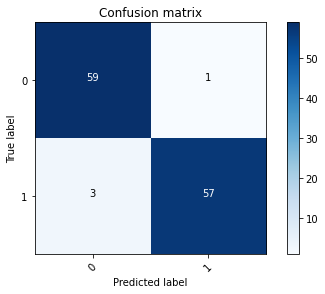

In [121]:
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [31]:
sum(cm_train, 0)

array([38, 52], dtype=int64)

In [122]:
re = recall(cm_train)
pre = precision(cm_train)
f1(pre, re)

recall
0: 0.9833333333333333
1: 0.95
precision
0: 0.9516129032258065
1: 0.9827586206896551
score:  {'0': 0.9672131147540983, '1': 0.9661016949152542}


# START: so sánh với predict cũ

In [26]:
model_path = "D:\\HoangNgan\\DoAn\\2022-03-03 07_56_11\\best_model.pt"
model = torch.load(model_path)

In [32]:
#way2shot2_unk
val_predict_label = []
val_real_label = []
dataset = way2shot2_unk
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)
    
#way2shot2_wh
dataset = way2shot2_wh
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)


C:\Users\Admins\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\Jupyter\Cough Classification\few-shot-ho-master\protonets\models\encoder\ResNet18_Attention.py:214: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


In [33]:
val_true, val_pred = val_real_label ,val_predict_label
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)

Confusion matrix: 
 [[57  3]
 [ 4 56]]


In [34]:
re = recall(cm_train)
pre = precision(cm_train)
f1(pre, re)

recall
0: 0.95
1: 0.9333333333333333
precision
0: 0.9344262295081968
1: 0.9491525423728814
score:  {'0': 0.9421487603305784, '1': 0.9411764705882353}


In [ ]:
#check data
recall
0: 0.5166666666666667
1: 0.9166666666666666
precision
0: 0.8611111111111112
1: 0.6547619047619048
score:  {'0': 0.6458333333333335, '1': 0.7638888888888888}
    
    
recall
0: 0.5333333333333333
1: 0.9333333333333333
precision
0: 0.8888888888888888
1: 0.6666666666666666
score:  {'0': 0.6666666666666667, '1': 0.7777777777777778}

In [ ]:
#way2shot2
recall
0: 0.95
1: 0.9333333333333333
precision
0: 0.9344262295081968
1: 0.9491525423728814
score:  {'0': 0.9421487603305784, '1': 0.9411764705882353}

# END

# TCResNet: distance

In [20]:
model_path = "D:\\HoangNgan\\DoAn\\paper\\exp\\few-shot-no-fed\\2022-05-28 095550_tcresnet_1set\\best_model.pt"
model = torch.load(model_path)

In [22]:
#way2shot2_unk
val_predict_label = []
val_real_label = []
dataset = way2shot2_unk
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)
    
#way2shot2_wh
dataset = way2shot2_wh
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)


Confusion matrix: 
 [[60  0]
 [ 0 60]]


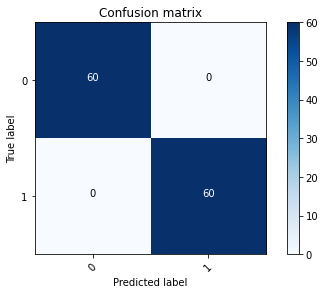

In [23]:
val_true, val_pred = val_real_label ,val_predict_label
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [24]:
re = recall(cm_train)
pre = precision(cm_train)
f1(pre, re)

recall
0: 1.0
1: 1.0
precision
0: 1.0
1: 1.0
score:  {'0': 1.0, '1': 1.0}


# TCResNetFed

In [123]:
model_path = "D:\\HoangNgan\\DoAn\\paper\\exp\\few-fed\\2022-05-09 05_51_23\\best_model.pt"
model = torch.load(model_path)

In [124]:
#way2shot2_unk
val_predict_label = []
val_real_label = []
dataset = way2shot2_unk
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)
    
#way2shot2_wh
dataset = way2shot2_wh
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)


Confusion matrix: 
 [[56  4]
 [16 44]]


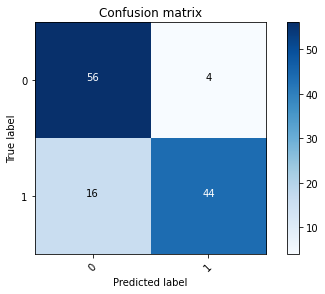

In [125]:
val_true, val_pred = val_real_label ,val_predict_label
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [126]:
re = recall(cm_train)
pre = precision(cm_train)
f1(pre, re)

recall
0: 0.9333333333333333
1: 0.7333333333333333
precision
0: 0.7777777777777778
1: 0.9166666666666666
score:  {'0': 0.8484848484848485, '1': 0.8148148148148148}


# ATT

In [127]:
model_path = "D:\\HoangNgan\\DoAn\\paper\\exp\\few-shot-no-fed\\2022-05-18 17_30_33_att_set1\\best_model.pt"
model = torch.load(model_path)

In [128]:
#way2shot2_unk
val_predict_label = []
val_real_label = []
dataset = way2shot2_unk
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)
    
#way2shot2_wh
dataset = way2shot2_wh
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)


C:\Users\Admins\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\Jupyter\Cough Classification\few-shot-ho-master\protonets\models\encoder\ResNet18_Attention.py:214: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


Confusion matrix: 
 [[41 19]
 [28 32]]


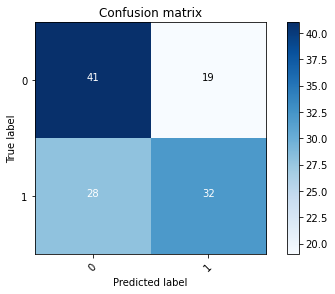

In [129]:
val_true, val_pred = val_real_label ,val_predict_label
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [130]:
re = recall(cm_train)
pre = precision(cm_train)
f1(pre, re)

recall
0: 0.6833333333333333
1: 0.5333333333333333
precision
0: 0.5942028985507246
1: 0.6274509803921569
score:  {'0': 0.6356589147286822, '1': 0.5765765765765766}


# ATT FED

In [131]:

model_path = "D:\\HoangNgan\\DoAn\\2022-03-03 07_56_11\\best_model.pt"
model = torch.load(model_path)

In [132]:
#way2shot2_unk
val_predict_label = []
val_real_label = []
dataset = way2shot2_unk
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)
    
#way2shot2_wh
dataset = way2shot2_wh
for key in dataset.keys():
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)


C:\Users\Admins\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\Jupyter\Cough Classification\few-shot-ho-master\protonets\models\encoder\ResNet18_Attention.py:214: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


Confusion matrix: 
 [[57  3]
 [ 4 56]]


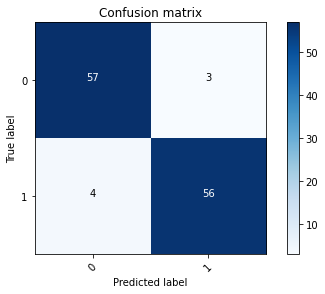

In [133]:
val_true, val_pred = val_real_label ,val_predict_label
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [134]:
re = recall(cm_train)
pre = precision(cm_train)
f1(pre, re)

recall
0: 0.95
1: 0.9333333333333333
precision
0: 0.9344262295081968
1: 0.9491525423728814
score:  {'0': 0.9421487603305784, '1': 0.9411764705882353}


# Updated version - Few-fed

ATT - KERNEL

In [137]:

model_path = "D:\\HoangNgan\\DoAn\\paper\\exp\\few-fed\\2022-05-21 07_33_52_att_kernel\\best_model.pt"
model = torch.load(model_path)

In [142]:
#way2shot2_unk
val_predict_label = []
val_real_label = []
dataset = way2shot2_unk
for key in dataset.keys():
#     print(key)
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)
    
#way2shot2_wh
dataset = way2shot2_wh
for key in dataset.keys():
#     print(key)
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)


Confusion matrix: 
 [[28 32]
 [26 34]]


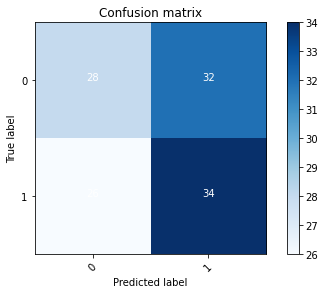

In [143]:
val_true, val_pred = val_real_label ,val_predict_label
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [144]:
re = recall(cm_train)
pre = precision(cm_train)
f1(pre, re)

recall
0: 0.4666666666666667
1: 0.5666666666666667
precision
0: 0.5185185185185185
1: 0.5151515151515151
score:  {'0': 0.4912280701754386, '1': 0.5396825396825397}


ATT - DILATION

In [146]:

model_path = "D:\\HoangNgan\\DoAn\\paper\\exp\\few-fed\\2022-05-21 22_43_14_att_dilation\\best_model.pt"
model = torch.load(model_path)

In [147]:
#way2shot2_unk
val_predict_label = []
val_real_label = []
dataset = way2shot2_unk
for key in dataset.keys():
#     print(key)
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)
    
#way2shot2_wh
dataset = way2shot2_wh
for key in dataset.keys():
#     print(key)
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)


C:\Users\Admins\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\Jupyter\Cough Classification\few-shot-ho-master\protonets\models\encoder\ResNet18_Attention_dilation_v2.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


Confusion matrix: 
 [[58  2]
 [ 9 51]]


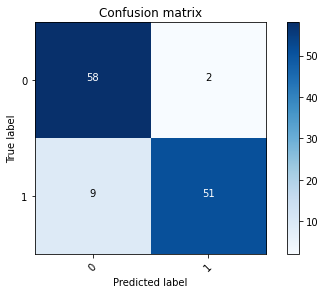

In [148]:
val_true, val_pred = val_real_label ,val_predict_label
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [149]:
re = recall(cm_train)
pre = precision(cm_train)
f1(pre, re)

recall
0: 0.9666666666666667
1: 0.85
precision
0: 0.8656716417910447
1: 0.9622641509433962
score:  {'0': 0.9133858267716535, '1': 0.9026548672566371}


ATT-KERNEL_DILATION-FED

In [17]:


model_path = "D:\\HoangNgan\\DoAn\\paper\\exp\\few-fed\\2022-05-23 07_11_45_att_kernel_dilation\\best_model.pt"
model = torch.load(model_path)

In [21]:
#way2shot2_unk
val_predict_label = []
val_real_label = []
dataset = way2shot2_unk
for key in dataset.keys():
#     print(key)
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)
    
#way2shot2_wh
dataset = way2shot2_wh
for key in dataset.keys():
#     print(key)
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)


C:\Users\Admins\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\Jupyter\Cough Classification\few-shot-ho-master\protonets\models\encoder\ResNet18_Attention_kernel_dilation_v2.py:218: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


Confusion matrix: 
 [[30 30]
 [33 27]]


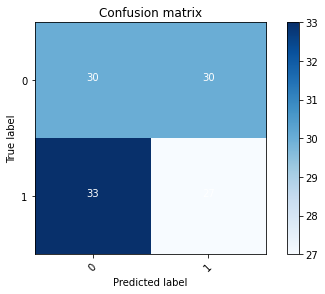

In [22]:
val_true, val_pred = val_real_label ,val_predict_label
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [23]:
re = recall(cm_train)
pre = precision(cm_train)
f1(pre, re)

recall
0: 0.5
1: 0.45
precision
0: 0.47619047619047616
1: 0.47368421052631576
score:  {'0': 0.4878048780487805, '1': 0.46153846153846156}


# Attention - kernel (ver 2)

In [15]:


model_path = "D:\\HoangNgan\\DoAn\\paper\\exp\\few-fed\\2022-05-29 05_11_56_attention_kernel\\best_model.pt"
model = torch.load(model_path)

In [16]:
#way2shot2_unk
val_predict_label = []
val_real_label = []
dataset = way2shot2_unk
for key in dataset.keys():
#     print(key)
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)
    
#way2shot2_wh
dataset = way2shot2_wh
for key in dataset.keys():
#     print(key)
    pred, label = predict(dataset, key)
    val_predict_label.append(pred)
    val_real_label.append(label)


C:\Users\Admins\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\Jupyter\Cough Classification\few-shot-ho-master\protonets\models\encoder\ResNet18_Attention_kernel_v2.py:216: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


Confusion matrix: 
 [[44 16]
 [26 34]]


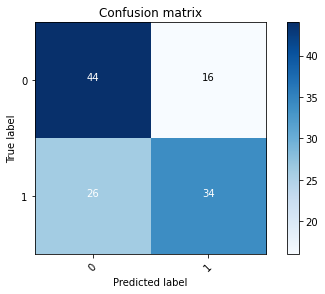

In [17]:
val_true, val_pred = val_real_label ,val_predict_label
cm_train = confusion_matrix(val_true, val_pred) 
print('Confusion matrix: \n', cm_train)
plot_confusion_matrix(cm_train, classes=['0','1'],
                      title='Confusion matrix')

In [18]:
re = recall(cm_train)
pre = precision(cm_train)
f1(pre, re)

recall
0: 0.7333333333333333
1: 0.5666666666666667
precision
0: 0.6285714285714286
1: 0.68
score:  {'0': 0.6769230769230768, '1': 0.6181818181818183}
